# MS004 Preprocess
06/13/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS004'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/MS004/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | MS004_SWB.edf, 148 x 2366080 (2310.6 s), ~2.61 GB, data loaded>

In [7]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'aLespM1',
 'aLespM2',
 'aLespM3',
 'aLespM4',
 'aLespM5',
 'aLespM6',
 'aLespM7',
 'aLespM8',
 'LespM1',
 'LespM2',
 'LespM3',
 'LespM4',
 'LespM5',
 'LespM6',
 'LespM7',
 'LespM8',
 'LespM9',
 'LespM10',
 'pLesHM1',
 'pLesHM2',
 'pLesHM3',
 'pLesHM4',
 'pLesHM5',
 'pLesHM6',
 'pLesHM7',
 'pLesHM8',
 'LlespM1',
 'LlespM2',
 'LlespM3',
 'LlespM4',
 'LlespM5',
 'LlespM6',
 'RLes21',
 'RLes22',
 'RLes23',
 'RLes24',
 'RLes25',
 'RLes26',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT

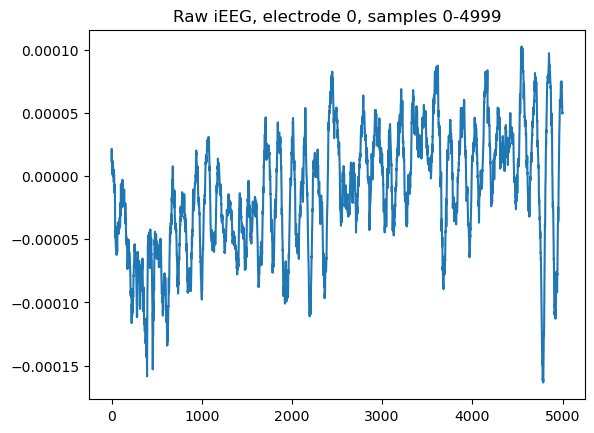

In [8]:
# Sanity check one channel data
plt.plot(mne_data._data[3,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

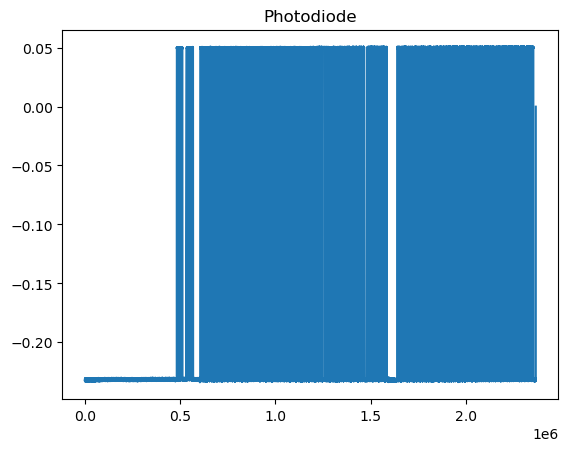

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [10]:
# Load the electrode localization data
ms004_anat_file = glob(f'{anat_dir}/MS004_labels.csv')[0]
elec_locs = pd.read_csv(ms004_anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,aLespM1,A23c_L,-10.199563,-1.399935,34.199994,-10.271708,-13.669751,40.042763,Gray,Left MCgG middle cingulate gyrus,Unknown,L MCC,L CG,Left cingulate gyrus L,WM,lesion
1,aLespM2,A23c_L,-11.799496,-0.199985,38.999994,-11.964828,-11.853191,45.469596,White,Left SMC supplementary motor cortex,Unknown,L MCC,L CG,Left superior frontal gyrus 7 A,WM,lesion
2,aLespM3,Unknown,-13.399429,0.599981,43.399993,-13.606759,-10.518773,50.487989,White,Left Cerebral White Matter,Unknown,L MCC,Unknown,Unknown,WM,lesion
3,aLespM4,Unknown,-14.999362,1.799931,48.199993,-15.345050,-8.725402,55.914290,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,lesion
4,aLespM5,A6dl_L,-16.599296,2.999881,52.999993,-17.126064,-6.877599,61.362621,White,Left SFG superior frontal gyrus,Unknown,L Posterior-Medial Frontal,L SFG,Unknown,lesion,lesion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,RmOlF5,Unknown,25.398950,35.798516,15.799995,28.472357,25.071580,17.516928,White,Right Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
98,RmOlF6,Unknown,28.998799,35.798516,18.999995,32.166475,25.487460,21.130085,White,Right Cerebral White Matter,Unknown,R Middle Frontal Gyrus,Unknown,Unknown,WM,NaN
99,RmOlF7,A9/46v_R,32.998632,34.998549,21.399995,36.411860,24.897113,24.029039,Gray,Right MFG middle frontal gyrus,Unknown,R IFG (p Triangularis),R MFG,Right middle frontal gyrus 4 B,NaN,NaN
100,RmOlF8,A8vl_R,36.998465,34.998549,24.199995,40.586243,25.242135,27.382506,Gray,Right MFG middle frontal gyrus,Unknown,R IFG (p Triangularis),R MFG,Unknown,Right middle frontal 4 B,NaN


In [11]:
list(elec_locs.label) #og file includes electrodes that were added after swb was ran

['aLespM1',
 'aLespM2',
 'aLespM3',
 'aLespM4',
 'aLespM5',
 'aLespM6',
 'aLespM7',
 'aLespM8',
 'LaCaS1',
 'LaCaS10',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LlespM1',
 'LlespM10',
 'LlespM2',
 'LlespM3',
 'LlespM4',
 'LlespM5',
 'LlespM6',
 'LlespM7',
 'LlespM8',
 'LlespM9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'uLmOlF',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'pLesHM1',
 'pLesHM2',
 'pLesHM3',
 'pLesHM4',
 'pLesHM5',
 'pLesHM6',
 'pLesHM7',
 'pLesHM8',
 'RaCaS1',
 'RaCaS10',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RHplT1',
 'RHplT10',
 'RHplT2',
 'RHplT3',
 'RHplT4',
 'RHplT5',
 'RHplT6',
 'RHplT7',
 'RHplT8',
 'RHplT9',
 'RLes21',
 'RLes22',
 'RLes23',
 'RLes24',
 'RLes25',
 'RLes26',
 'RLes27',
 'RLes28',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 

In [12]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [13]:
unmatched_seeg #make sure there are no unmatched names

[]

In [14]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [15]:
new_name_dict

{'LmOlF1': 'lmolf1',
 'LmOlF2': 'lmolf2',
 'LmOlF3': 'lmolf3',
 'LmOlF4': 'lmolf4',
 'LmOlF5': 'lmolf5',
 'LmOlF6': 'lmolf6',
 'LmOlF7': 'lmolf7',
 'LmOlF8': 'lmolf8',
 'LmOlF9': 'lmolf9',
 'RmOlF1': 'rmolf1',
 'RmOlF2': 'rmolf2',
 'RmOlF3': 'rmolf3',
 'RmOlF4': 'rmolf4',
 'RmOlF5': 'rmolf5',
 'RmOlF6': 'rmolf6',
 'RmOlF7': 'rmolf7',
 'RmOlF8': 'rmolf8',
 'RmOlF9': 'rmolf9',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'RaCaS1': 'racas1',
 'RaCaS2': 'racas2',
 'RaCaS3': 'racas3',
 'RaCaS4': 'racas4',
 'RaCaS5': 'racas5',
 'RaCaS6': 'racas6',
 'RaCaS7': 'racas7',
 'RaCaS8': 'racas8',
 'RaCaS9': 'racas9',
 'RaCaS10': 'racas10',
 'RmCmS1': 'rmcms1',
 'RmCmS2': 'rmcms2',
 'RmCmS3': 'rmcms3',
 'RmCmS4': 'rmcms4',
 'RmCmS5': 'rmcms5',
 'RmCmS6': 'rmcms6',
 'RmCmS7': 'rmcms7',
 'RmCmS8': 'rmcms8',
 'aLespM1': 'alespm1',
 'aLesp

In [16]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS004_SWB.edf, 148 x 2366080 (2310.6 s), ~2.61 GB, data loaded>

In [17]:
unmatched_seeg 

[]

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lespm1', 'lespm2', 'lespm3', 'lespm4', 'lespm5', 'lespm6', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', '02', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c126', 'c127', 'c128', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [19]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 44 left & 44 right sEEG electrodes
We have a total of 88 sEEG electrodes


In [20]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['alespm7',
 'c127',
 'pleth',
 'dc7',
 'dc13',
 'pr',
 'p4',
 'dc2',
 'alespm2',
 'pz',
 'pleshm1',
 'alespm5',
 't3',
 'pleshm6',
 'c3',
 'pleshm4',
 'c126',
 'fz',
 'dc12',
 'cz',
 'dc3',
 'alespm1',
 'c128',
 'osat',
 'dc9',
 'fp2',
 'trig',
 'dc5',
 't4',
 'fp1',
 'dc8',
 'alespm8',
 'pleshm8',
 'ekg2',
 't5',
 'alespm6',
 'dc11',
 'f3',
 't6',
 'pleshm5',
 'o1',
 'dc14',
 'c4',
 'ekg1',
 'f8',
 'pleshm2',
 'dc4',
 'alespm3',
 'f7',
 'alespm4',
 '02',
 'dc15',
 'pleshm7',
 'f4',
 'dc16',
 'p3',
 'dc6',
 'dc10',
 'pleshm3']

In [21]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS004_SWB.edf, 89 x 2366080 (2310.6 s), ~1.57 GB, data loaded>

In [22]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #'stim test1-ref' 'Stim TEST1-REF' stim stands for stimulus 
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS004_SWB.edf, 89 x 2366080 (2310.6 s), ~1.57 GB, data loaded>

In [23]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS004_SWB.edf, 89 x 2366080 (2310.6 s), ~1.57 GB, data loaded>

### Notch filter line noise

In [24]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    4.7s finished


<RawEDF | MS004_SWB.edf, 89 x 2366080 (2310.6 s), ~1.57 GB, data loaded>

In [43]:
mne_data.save(f'{neural_dir}/MS004/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [25]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
mne_data.info['bads'] = bads

#resampling this patient is not necessary 
# resample_sr = 500
# mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

### Save out photodiode data
Note: this is after filtering out line noise

In [26]:
bads

['lacas1', 'lacas2', 'lespm1', 'llespm10', 'llespm9', 'rmcms6', 'rmcms7']

In [27]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [28]:
probe_names

array(['alespm', 'lacas', 'lhplt', 'llespm', 'lmolf', 'pleshm', 'racas',
       'rhplt', 'rles', 'rmcms', 'rmolf', 'ulmolf', 'urmolf'], dtype='<U6')

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'alespm': 8,
 'lacas': 10,
 'lhplt': 10,
 'llespm': 10,
 'lmolf': 9,
 'pleshm': 8,
 'racas': 10,
 'rhplt': 10,
 'rles': 8,
 'rmcms': 8,
 'rmolf': 9,
 'ulmolf': 1,
 'urmolf': 1}

<IPython.core.display.Javascript object>


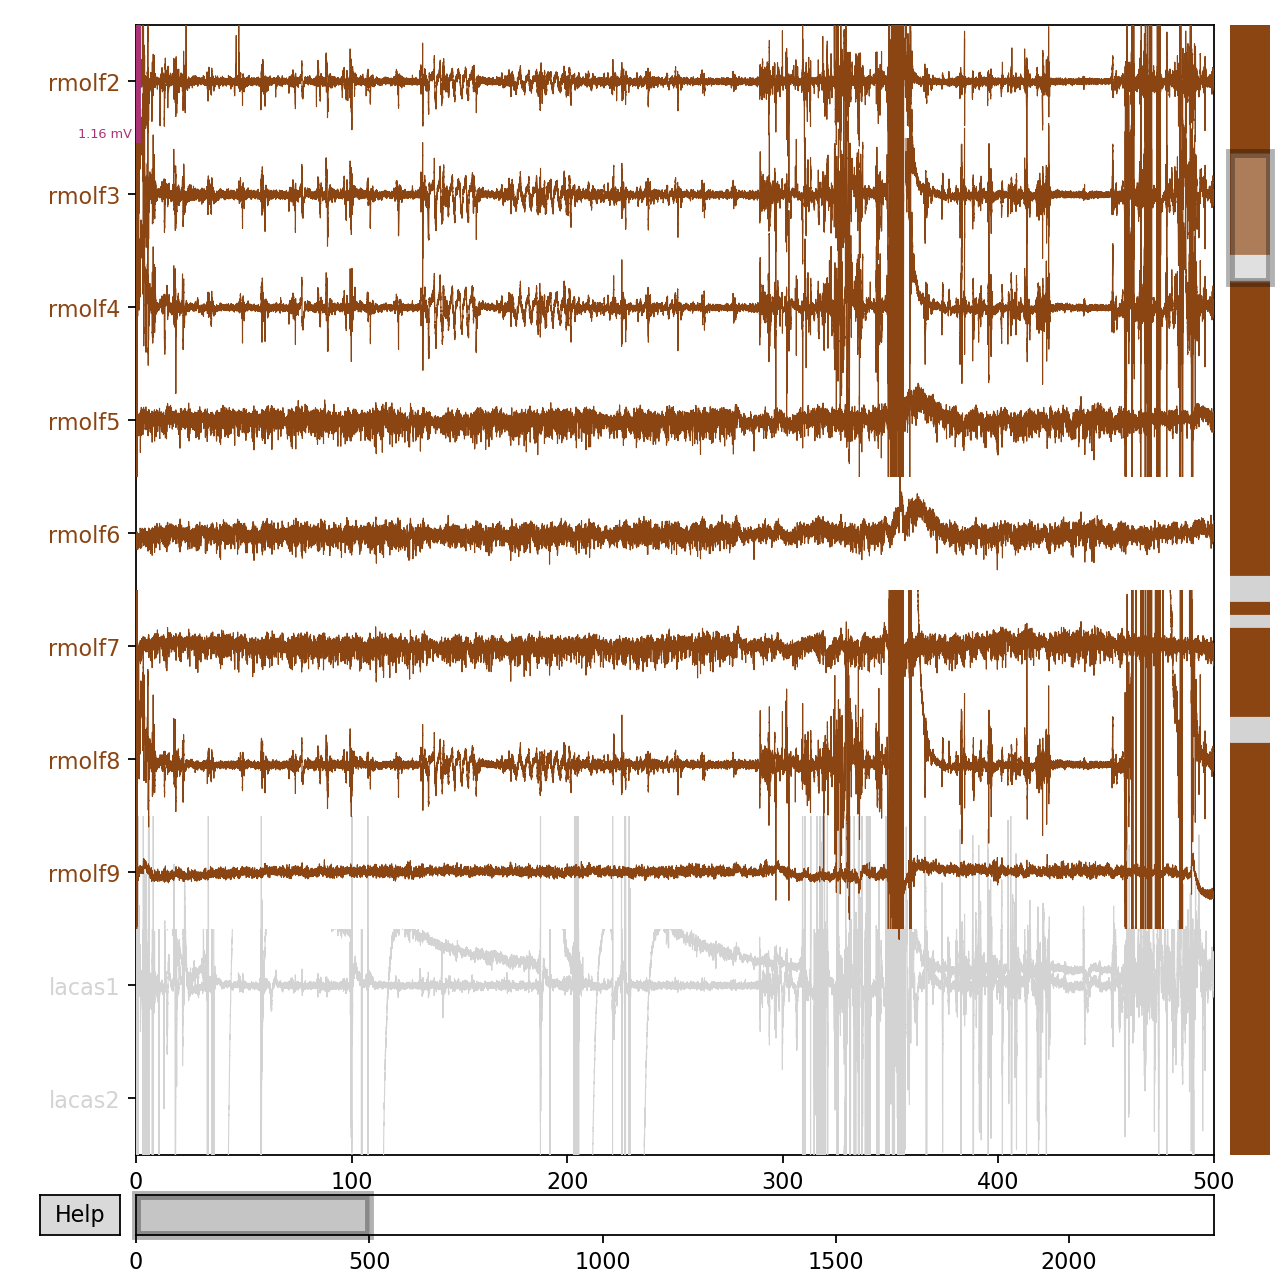

<IPython.core.display.Javascript object>


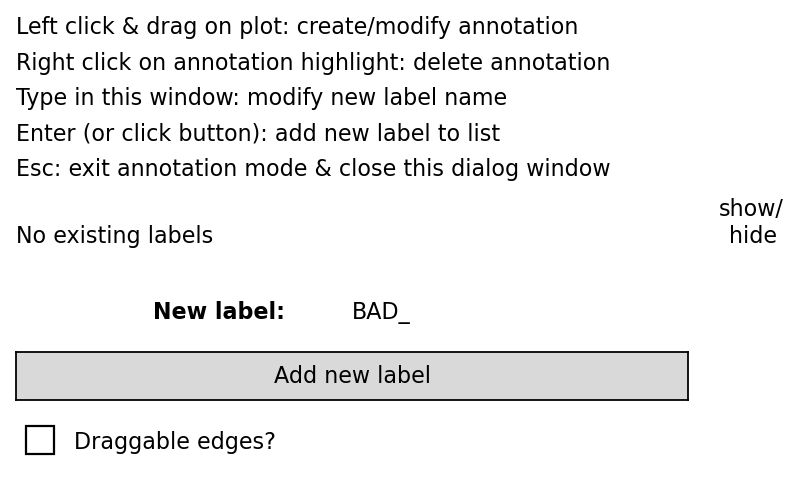

In [31]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

<IPython.core.display.Javascript object>


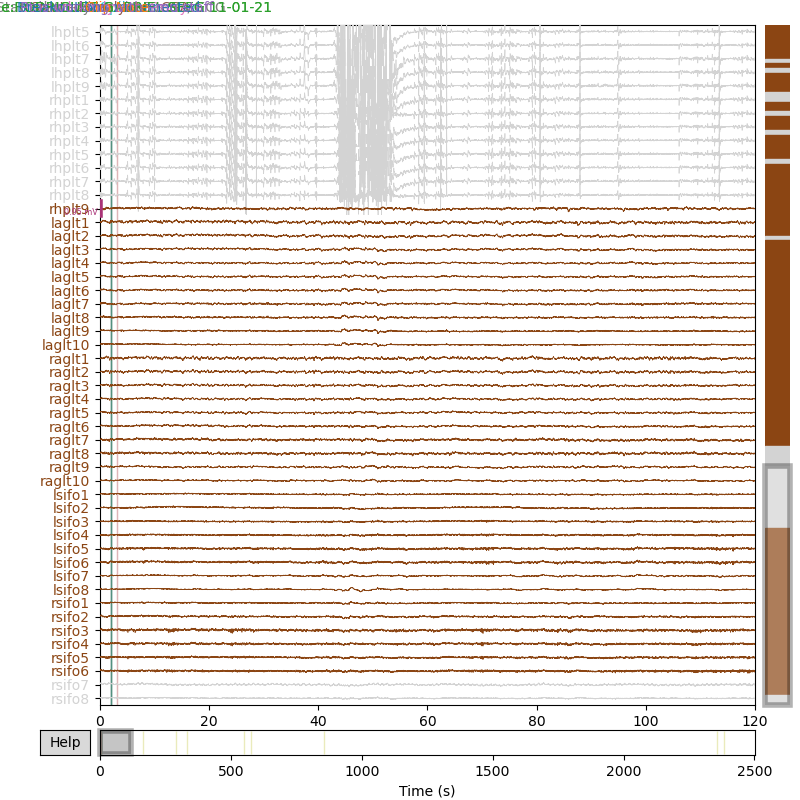

<IPython.core.display.Javascript object>


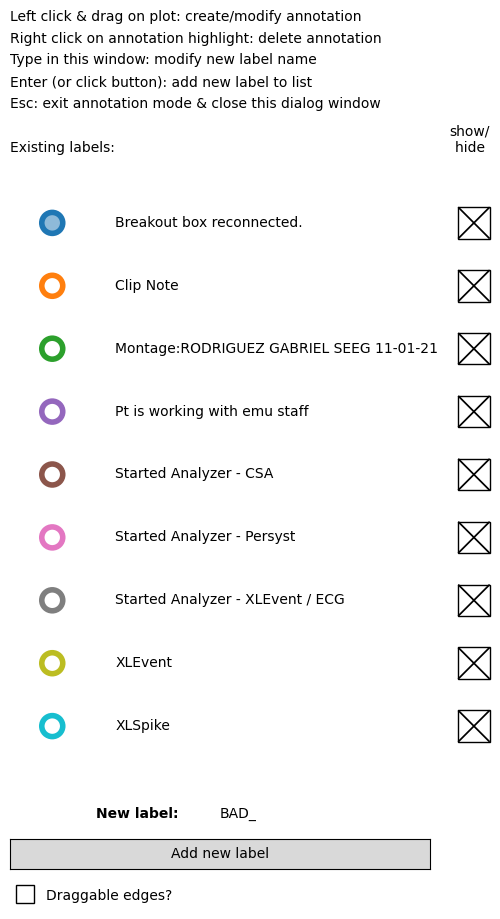

In [59]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [62]:
mne_data.info['bads']

['lmolf8',
 'rmolf1',
 'rmolf6',
 'rmolf7',
 'lacas1',
 'lacas5',
 'lacas11',
 'lmcms3',
 'lhplt1',
 'lhplt2',
 'lhplt3',
 'lhplt4',
 'lhplt5',
 'lhplt6',
 'lhplt7',
 'lhplt8',
 'lhplt9',
 'rhplt1',
 'rhplt2',
 'rhplt3',
 'rhplt4',
 'rhplt5',
 'rhplt6',
 'rhplt7',
 'rhplt8',
 'rsifo7',
 'rsifo8']

In [63]:
#set bad channel info 
ms003_bad_ch = ['lmolf8',
 'rmolf1',
 'rmolf6',
 'rmolf7',
 'lacas1',
 'lacas5',
 'lacas11',
 'lmcms3',
 'lhplt1',
 'lhplt2',
 'lhplt3',
 'lhplt4',
 'lhplt5',
 'lhplt6',
 'lhplt7',
 'lhplt8',
 'lhplt9',
 'rhplt1',
 'rhplt2',
 'rhplt3',
 'rhplt4',
 'rhplt5',
 'rhplt6',
 'rhplt7',
 'rhplt8',
 'rsifo7',
 'rsifo8']

In [65]:
len(ms003_bad_ch)

27

In [66]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = ms003_bad_ch 

In [67]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 27 items (lmolf8, rmolf1, rmolf6, rmolf7, lacas1, lacas5, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 142 sEEG
 custom_ref_applied: False
 dig: 142 items (142 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 10:06:23 UTC
 nchan: 142
 projs: []
 sfreq: 512.0 Hz
>

In [68]:
mne_data.info['bads'] #more sanity checking

['lmolf8',
 'rmolf1',
 'rmolf6',
 'rmolf7',
 'lacas1',
 'lacas5',
 'lacas11',
 'lmcms3',
 'lhplt1',
 'lhplt2',
 'lhplt3',
 'lhplt4',
 'lhplt5',
 'lhplt6',
 'lhplt7',
 'lhplt8',
 'lhplt9',
 'rhplt1',
 'rhplt2',
 'rhplt3',
 'rhplt4',
 'rhplt5',
 'rhplt6',
 'rhplt7',
 'rhplt8',
 'rsifo7',
 'rsifo8']

### Rereference data to wm electrodes

In [69]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=ms003_anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [70]:
oob_channels

['lacas11',
 'lacas12',
 'laglt10',
 'laimm12',
 'lmcms10',
 'lmolf9',
 'lsifo8',
 'racas12',
 'raglt10',
 'raimm14',
 'rmcms10',
 'rsifo8']

In [71]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
ms003_bad_ch = ms003_bad_ch + oob_channels
ms003_bad_ch = list(np.unique(ms003_bad_ch))
mne_data.info['bads'] = ms003_bad_ch

In [72]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas1',
 'lacas11',
 'lacas12',
 'lacas5',
 'laglt10',
 'laimm12',
 'lhplt1',
 'lhplt2',
 'lhplt3',
 'lhplt4',
 'lhplt5',
 'lhplt6',
 'lhplt7',
 'lhplt8',
 'lhplt9',
 'lmcms10',
 'lmcms3',
 'lmolf8',
 'lmolf9',
 'lsifo8',
 'racas12',
 'raglt10',
 'raimm14',
 'rhplt1',
 'rhplt2',
 'rhplt3',
 'rhplt4',
 'rhplt5',
 'rhplt6',
 'rhplt7',
 'rhplt8',
 'rmcms10',
 'rmolf1',
 'rmolf6',
 'rmolf7',
 'rsifo7',
 'rsifo8']

In [73]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [74]:
mne_data_reref

<RawEDF | MS003_SWB.edf, 110 x 1281024 (2502.0 s), ~1.05 GB, data loaded>

### Save cleaned continuous data

In [63]:
mne_data.save(f'{neural_dir}/MS003/lfp_data.fif',overwrite=True)

In [64]:
mne_data_reref.save(f'{neural_dir}/MS002/wm_ref_ieeg.fif',overwrite=True)